Using device: cuda
元のODEの解を表示します...


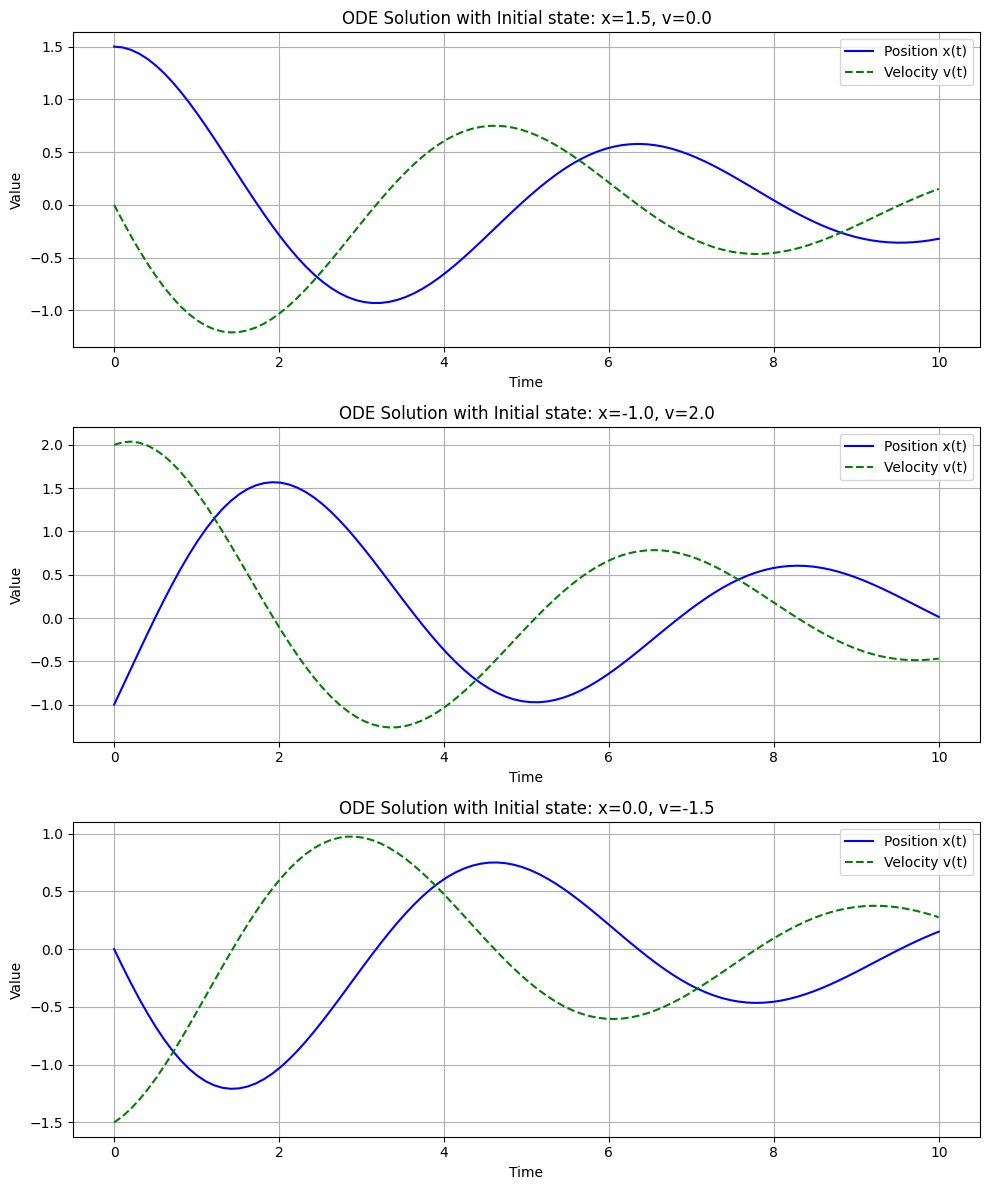

訓練データを生成中...
Neural ODEをトレーニング中...
Epoch 0, Loss: 1.569728
Epoch 1, Loss: 0.530212
Epoch 2, Loss: 0.451360
Epoch 3, Loss: 0.420994
Epoch 4, Loss: 0.400115
Epoch 5, Loss: 0.382902
Epoch 6, Loss: 0.367917
Epoch 7, Loss: 0.354520
Epoch 8, Loss: 0.342294
Epoch 9, Loss: 0.330948
Epoch 10, Loss: 0.320265
Epoch 11, Loss: 0.310076
Epoch 12, Loss: 0.300240
Epoch 13, Loss: 0.290632
Epoch 14, Loss: 0.281135
Epoch 15, Loss: 0.271632
Epoch 16, Loss: 0.261997
Epoch 17, Loss: 0.252084
Epoch 18, Loss: 0.241718
Epoch 19, Loss: 0.230670
Epoch 20, Loss: 0.218629
Epoch 21, Loss: 0.205156
Epoch 22, Loss: 0.189594
Epoch 23, Loss: 0.170956
Epoch 24, Loss: 0.147831
Epoch 25, Loss: 0.119109
Epoch 26, Loss: 0.090025
Epoch 27, Loss: 0.080025
Epoch 28, Loss: 0.067874
Epoch 29, Loss: 0.063763
Epoch 30, Loss: 0.054370
Epoch 31, Loss: 0.052515
Epoch 32, Loss: 0.045335
Epoch 33, Loss: 0.044900
Epoch 34, Loss: 0.039460
Epoch 35, Loss: 0.039571
Epoch 36, Loss: 0.035605
Epoch 37, Loss: 0.035684
Epoch 38, Loss: 0.032879


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchdiffeq import odeint
from scipy.integrate import solve_ivp

# GPUが利用可能かどうか確認
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ステップ1: 微分方程式の定義 (減衰振動)
# dx/dt = v
# dv/dt = -k*x - b*v


class DampedOscillatorSystem:
    def __init__(self, k=1.0, b=0.1):
        self.k = k  # バネ定数
        self.b = b  # 減衰係数

    def __call__(self, t, state):
        x, v = state
        dxdt = v
        dvdt = -self.k * x - self.b * v
        return [dxdt, dvdt]

    def solve(self, initial_state, t_span, t_eval):
        """通常のソルバーを使用して解く"""
        sol = solve_ivp(
            self.__call__,
            t_span,
            initial_state,
            t_eval=t_eval,
            method='RK45'
        )
        return sol.t, sol.y

# ステップ2: 訓練データの生成


def generate_training_data(system, n_samples=20, t_max=10.0, n_points=100):
    t_span = (0, t_max)
    t_eval = np.linspace(0, t_max, n_points)

    train_data = []

    # 様々な初期条件で解を生成
    for _ in range(n_samples):
        # ランダムな初期条件 (位置x, 速度v)
        x0 = np.random.uniform(-2.0, 2.0)
        v0 = np.random.uniform(-2.0, 2.0)
        initial_state = [x0, v0]

        # システムを解く
        t, y = system.solve(initial_state, t_span, t_eval)

        # データ形式: (時間点, 初期状態, 全時間での状態) - GPUに移動
        train_data.append((
            t,
            torch.tensor(initial_state, dtype=torch.float32).to(device),
            torch.tensor(y.T, dtype=torch.float32).to(device)
        ))

    return train_data

# ステップ3: Neural ODEモデルの定義


class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=20):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, t, y):
        """
        t: 時間
        y: 状態 [x, v]
        """
        return self.net(y)


# ステップ4: モデルのトレーニング
def train_neural_ode(ode_func, train_data, n_epochs=2000, lr=1e-3):
    optimizer = torch.optim.Adam(ode_func.parameters(), lr=lr)  # type: ignore

    losses = []

    for epoch in range(n_epochs):
        batch_loss = 0

        for t_points, initial_state, true_trajectory in train_data:
            # Neural ODEを使って予測 - GPUに移動
            t_tensor = torch.tensor(t_points, dtype=torch.float32).to(device)
            pred_trajectory = odeint(ode_func, initial_state, t_tensor)

            # 損失計算
            loss = torch.mean((pred_trajectory - true_trajectory)**2)

            # 最適化ステップ
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        avg_loss = batch_loss / len(train_data)
        losses.append(avg_loss)

        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

    return losses


# ステップ5: 結果の可視化
def plot_comparison(system, ode_func, initial_states, t_max=10.0, n_points=100):
    t_span = (0, t_max)
    t_eval = np.linspace(0, t_max, n_points)
    t_tensor = torch.tensor(t_eval, dtype=torch.float32).to(device)

    fig, axes = plt.subplots(len(initial_states), 1,
                             figsize=(10, 4*len(initial_states)))
    if len(initial_states) == 1:
        axes = [axes]

    for i, initial_state in enumerate(initial_states):
        # 通常のソルバーで解く
        t, y_true = system.solve(initial_state, t_span, t_eval)
        x_true, v_true = y_true

        # Neural ODEで解く
        initial_tensor = torch.tensor(
            initial_state, dtype=torch.float32).to(device)
        y_pred = odeint(ode_func, initial_tensor, t_tensor)
        # type: ignore # GPUからCPUに移動してからNumPyに変換
        y_pred = y_pred.detach().cpu().numpy()
        x_pred, v_pred = y_pred[:, 0], y_pred[:, 1]

        # プロット
        ax = axes[i]
        ax.plot(t, x_true, 'b-', label='True x(t)')
        ax.plot(t, x_pred, 'r--', label='Neural ODE x(t)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Position x')
        ax.set_title(
            f'Initial state: x={initial_state[0]}, v={initial_state[1]}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    return fig

# 元のODEの解を表示する関数


def plot_original_ode_solutions(system, initial_states, t_max=10.0, n_points=100):
    t_span = (0, t_max)
    t_eval = np.linspace(0, t_max, n_points)

    fig, axes = plt.subplots(len(initial_states), 1,
                             figsize=(10, 4*len(initial_states)))
    if len(initial_states) == 1:
        axes = [axes]

    for i, initial_state in enumerate(initial_states):
        # 通常のソルバーで解く
        t, y = system.solve(initial_state, t_span, t_eval)
        x, v = y

        # プロット
        ax = axes[i]
        ax.plot(t, x, 'b-', label='Position x(t)')
        ax.plot(t, v, 'g--', label='Velocity v(t)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_title(
            f'ODE Solution with Initial state: x={initial_state[0]}, v={initial_state[1]}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    return fig


# メイン関数
def main():
    # システムの設定
    k = 1.0  # バネ定数
    b = 0.3  # 減衰係数
    system = DampedOscillatorSystem(k=k, b=b)

    # まず、元のODEの解を表示
    print("元のODEの解を表示します...")
    test_initial_states = [
        [1.5, 0.0],   # 位置=1.5, 速度=0
        [-1.0, 2.0],  # 位置=-1.0, 速度=2.0
        [0.0, -1.5]   # 位置=0.0, 速度=-1.5
    ]
    fig = plot_original_ode_solutions(system, test_initial_states)
    plt.show()

    # 訓練データ生成
    print("訓練データを生成中...")
    train_data = generate_training_data(system, n_samples=20, t_max=10.0)

    # Neural ODEモデルの構築
    ode_func = ODEFunc(hidden_dim=32).to(device)  # モデルをGPUに移動

    # モデルのトレーニング
    print("Neural ODEをトレーニング中...")
    losses = train_neural_ode(ode_func, train_data, n_epochs=2000)

    # 損失のプロット
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()

    # テスト用の初期条件
    test_initial_states = [
        [1.5, 0.0],   # 位置=1.5, 速度=0
        [-1.0, 2.0],  # 位置=-1.0, 速度=2.0
        [0.0, -1.5]   # 位置=0.0, 速度=-1.5
    ]

    # 結果の比較・可視化
    fig = plot_comparison(system, ode_func, test_initial_states)
    plt.show()


main()